## Introduction to Deep Neural Networks

The goal of this lab is to set up a deep neural network using PyTorch. A lot of starter code will be given to you, and the student is expected to build the network aspects. The network should be customizable for a basic linear/logistic model, a linear model with polynomial feature extraction, a model with a hidden layer relu for feature extraction, and a deep neural network

The datasets analyzed will be selected in the beginning of the notebook (with no required code changes besides a bit switch) from either

1 - https://www.kaggle.com/osmi/mental-health-in-tech-survey
A Kaggle dataset about mental health. The goal of this dataset is to utilize a set of categorical and numeric features to predict 'treatment: Have you sought treatment for a mental health condition?'

2 - MNIST
A standard ML dataset. The input features are grayscale images of numbers, the goal is to predict the number [0-9]. In this homework we simplify it to binary classification [0-4] vs [5-9]

In [1]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import datetime
from torch import nn
from torch.nn import init
from torch.autograd import Variable

Code to pre-process Datasets

In [2]:
def process_mental_health(df):
    one_hot = ['Gender', 'Country', 'state', 'self_employed', 
               'family_history', 'work_interfere', 'no_employees',
               'remote_work', 'tech_company', 'benefits', 'care_options',
               'wellness_program', 'seek_help', 'anonymity', 'leave',
               'mental_health_consequence', 'phys_health_consequence', 'coworkers',
               'supervisor', 'mental_health_interview', 'phys_health_interview',
               'mental_vs_physical', 'obs_consequence']
    numeric = ['Age']
    timestamp_to_numeric = ['Timestamp']

    data = df.loc[:,'treatment']
    data = data.str.replace('No', '1').str.replace('Yes', '0').astype(float)

    for col in one_hot:
        new_data = df.loc[:,col]
        if new_data.unique().shape[0] < 2:
            #Throw away column if constant
            continue
        elif new_data.unique().shape[0] == 2:
            #If two values, create binary representation
            new_data = (new_data == new_data.unique()[0]).astype(float)
        else:
            #If more than two unique values, create one hot representation
            new_data = pd.get_dummies(new_data)
        data = pd.concat((data, new_data), 1)

    for col in numeric:
        new_data = df.loc[:,col]
        new_data = new_data.astype(float)
        data = pd.concat((data, new_data), 1)

    for col in timestamp_to_numeric:
        new_data = df.loc[:,col]
        new_data = pd.to_numeric(pd.to_datetime(new_data))
        data = pd.concat((data, new_data), 1)

    #Convert data pandas to numpy
    data = data.as_matrix()
    return data

def process_mnist():
    import torchvision
    data = torchvision.datasets.MNIST(root='.', download=True)
    train_data = data.train_data.numpy().reshape(60000, -1)
    train_labels = data.train_labels.numpy().reshape(60000, -1)

    data_test = torchvision.datasets.MNIST(root='.', download=True, train=False)
    test_data = data_test.test_data.numpy().reshape(10000, -1)
    test_labels = data_test.test_labels.numpy().reshape(10000, -1)

    data = np.concatenate([train_data, test_data], axis=0)
    labels = np.concatenate([train_labels, test_labels], axis=0)
    labels = np.isin(labels,[1, 2, 4, 7, 9]).astype(float)
    data = np.concatenate([labels, data], axis=1)

    return data

# Dataset Selection

In [3]:
if 0:# dataset is mental health
    df = pd.read_csv('mental_health_survey.csv')
    data = process_mental_health(df)
    dataset = 'health'
else:#Choose MNIST
    data = process_mnist()
    dataset = 'mnist'

# Dataset-independent processing

Regardless of dataset, here we perform basic functions to split training vs testing and normalize data

In [4]:
#Check the final shape of our in-use dataset
print('data shape', data.shape)

#Feature shapes
num_rows, num_features = data.shape[0], data.shape[1]-1

#Select Training rows
np.random.seed(0)
trn_rows = np.sort(np.random.choice(num_rows, size = int(num_rows * .7), replace = False))

#Select Validation rows
val_rows = np.setdiff1d(np.arange(num_rows), trn_rows)

#Split dataset
trn_data, val_data = data[trn_rows,1:], data[val_rows,1:]
trn_Y, val_Y = data[trn_rows,0], data[val_rows,0]

#already normalized when appropriate
#Normalize training and validation based on training data
data_mean, data_std = trn_data.mean(0), trn_data.std(0) + 1e-8

def normalize_data(data, data_mean, data_std):
    normalized = (data - np.expand_dims(data_mean,0)) / np.expand_dims(data_std,0)
    normalized = np.clip(normalized, -5, 5)
    return normalized

trn_normalized = normalize_data(trn_data, data_mean, data_std)
val_normalized = normalize_data(val_data, data_mean, data_std)

data shape (70000, 785)


In [5]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 
# Base code from Andy Gan (Github BarclayII) with some minor additions

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 1

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

In [6]:
#Build the network in pytorch

def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    #Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,num_inputs, hidden_layers, output_fcn = None, 
                 lr = 1e-3, polynomial_features = False, weight_decay=1e-3):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        #output_fcn should be either 'linear' or 'logistic'
        nn.Module.__init__(self)
        self.num_inputs = num_inputs
        self.output_type = output_fcn
        
        prev_out_size = num_inputs
        self.hidden_layers = nn.ModuleList()
        
        self.trn_losses = []
        self.val_losses = []
        self.trn_accs = []
        self.val_accs = []
        self.fscores = []
        self.relu = nn.Sigmoid()
        self.polynomial_features = polynomial_features
        if polynomial_features:
            prev_out_size = prev_out_size * (prev_out_size + 1)
        for l in hidden_layers:
            self.hidden_layers.append(nn.Linear(prev_out_size, l))
            prev_out_size = l
        self.output_layer = nn.Linear(prev_out_size, 1)
        
        if output_fcn == 'linear':
            self.output_fcn = Identity()
            self.loss_fcn = nn.MSELoss()
        elif output_fcn == 'logistic':
            self.output_fcn = nn.Sigmoid()
            self.loss_fcn = nn.BCELoss()
        else:
            raise ValueError('output function must be linear or logistic')
            
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = lr, weight_decay = weight_decay)
        init_weights(self)
        
    def forward(self, x):
        #x is training data of shape [batch_size, num_inputs]
        x = tovar(x).float()
        if self.polynomial_features:
            rows, cols = x.size()
            x_left = torch.cat((x.view((rows, cols, 1)), tovar(torch.ones((rows, 1, 1)))), 1)
            x_right = x.view((rows, 1, cols))
            x = x_left.bmm(x_right).view((rows, cols*(cols+1)))
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        out_raw = self.output_layer(x)
        return self.output_fcn(out_raw).view(-1)


In [7]:
cutoff = .5
def num_accurate(y_pred, y):
    high = ((y_pred > cutoff) * (y == 1)).sum()
    low = ((y_pred < cutoff) * (y == 0)).sum()
    return high + low

def confusion_matrix(y_pred, y):
    TP = ((y_pred > cutoff) * (y == 1)).sum()
    TN = ((y_pred < cutoff) * (y == 0)).sum()
    FP = ((y_pred > cutoff) * (y == 0)).sum()
    FN = ((y_pred < cutoff) * (y == 1)).sum()
    confusion_matrix = np.array([[TP, FP], [FN, TN]])
    return confusion_matrix

def F1_score(y_pred, y):
    TP = ((y_pred > cutoff) * (y == 1)).sum()
    TN = ((y_pred < cutoff) * (y == 0)).sum()
    FP = ((y_pred > cutoff) * (y == 0)).sum()
    FN = ((y_pred < cutoff) * (y == 1)).sum()
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    return np.sqrt(precision * recall)

def train(epochs = 30, verbosity = 0, val_freq = 1):
    num_epochs = epochs
    if dataset == 'health':
        bs = 32
    if dataset == 'mnist':
        bs = 256
    rows_trn = len(trn_Y)
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        trn_acc = [0,0]
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            x, y = trn_normalized[rows,:], trn_Y[rows]
            
            y_pred = model(x)
            
            loss = model.loss_fcn(y_pred, tovar(y).float())

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            trn_acc[0] += num_accurate(y_pred_numpy, y)
            trn_acc[1] += len(rows)
        if epoch % val_freq == 0:
            #Evaluate Performance on on validation set
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            y_pred = model(val_normalized)
            val_loss = model.loss_fcn(y_pred, tovar(val_Y).float()).data[0]
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            val_acc = num_accurate(y_pred_numpy, val_Y) / len(val_Y)
            trn_acc = trn_acc[0] / trn_acc[1]
            if verbosity > 0 and epoch == num_epochs - 1:
                print('confusion matrix')
                print(confusion_matrix(y_pred_numpy, val_Y))
            if verbosity > 1:
                print( 'epoch:', epoch)
                print('train loss: ',trn_loss, 'train acc', trn_acc)
                print('val loss: ',val_loss, 'val acc', val_acc)
            fscore = F1_score(y_pred_numpy, val_Y)
            trn_loss = []
            model.val_losses.append(val_loss)
            model.val_accs.append(val_acc)
            model.trn_accs.append(trn_acc)
            model.fscores.append(fscore)
def visualize(verbosity = 0):
    #Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    print('Best Acc:', max(model.val_accs))
    print('Best F score:', max(model.fscores))
    plt.close()     
    if verbosity > 0:
        plt.plot(model.trn_losses, label='train loss')
        plt.plot(model.val_losses, label='val loss')
        plt.legend()
        plt.title('losses')
        plt.show()
        plt.figure()
    plt.plot(model.trn_accs, label='train acc')
    plt.plot(model.val_accs, label='val acc')
    plt.legend()
    plt.title('accuracies')
    plt.show()
    plt.figure()
    plt.plot(model.fscores, label='val f score')
    plt.legend()
    plt.title('F scores')
    plt.show()

Now the code is done so lets test our model with different parameter settings!

In [8]:
num_epochs = 100
verb = 0
if dataset == 'health':
    hidden_width = 1000
if dataset == 'mnist':
    hidden_width = 100

Best Loss: 0.20894969999790192
Best Acc: 0.926333333333
Best F score: 0.928600994919


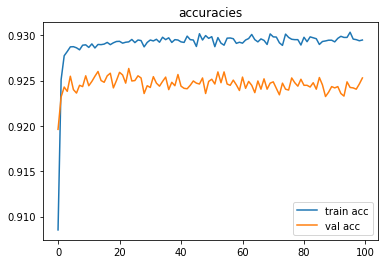

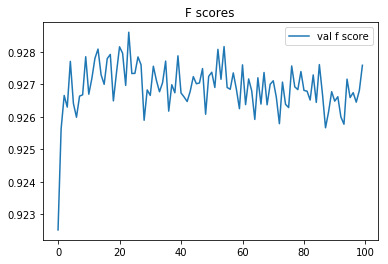

In [9]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()

In [10]:
if dataset == 'health':
    model = cuda(Model(num_features, hidden_layers = [], 
                       output_fcn = 'logistic', polynomial_features = True,weight_decay = 1e-1))
    train(epochs = num_epochs, verbosity = verb)
    visualize()

Best Loss: 0.04715357720851898
Best Acc: 0.986761904762
Best F score: 0.987094204513


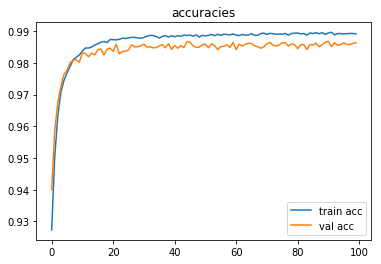

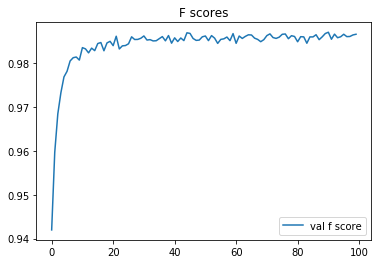

In [11]:

model = cuda(Model(num_features, hidden_layers = [hidden_width], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()

Best Loss: 0.03818000480532646
Best Acc: 0.989142857143
Best F score: 0.98939851709


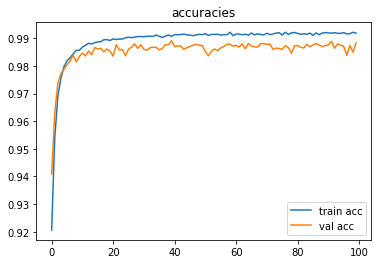

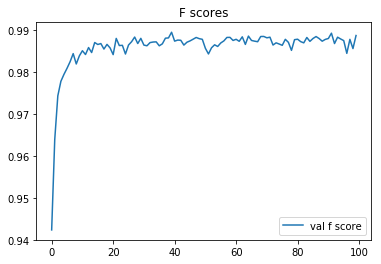

In [12]:

model = cuda(Model(num_features, hidden_layers = [hidden_width, hidden_width], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()